In [134]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import copy

%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_all_font_sizes(16)
from utils import roi_utils, default_paths, stats_utils

In [135]:
# Load results of the fitting procedure

subject = 1
volume_space=True
feature_type_list_long = ['clip_RN50_best_layer_pca']
feature_type_list = ['clip']
nf = [0]

for fi, fitting_type in enumerate(feature_type_list_long):
    out= load_fits.load_fit_results(subject, fitting_type,n_from_end=nf[fi],verbose=True);

    if fi==0:
        n_voxels = out['sem_corr_each_axis'].shape[0]
        n_discrim_types = out['sem_discrim_each_axis'].shape[1]
        sem_corr = np.zeros((len(feature_type_list), n_discrim_types, n_voxels))
        sem_discrim = np.zeros((len(feature_type_list), n_discrim_types, n_voxels))
        clip_r2 = np.zeros((n_voxels,))
        discrim_type_list = out['discrim_type_list']
        
    sem_corr[fi,:,:] = out['sem_corr_each_axis'].T
    sem_discrim[fi,:,:] = out['sem_discrim_each_axis'].T
    
    if 'clip' in fitting_type:
        clip_r2 = out['val_r2'][:,0]

np.all(np.isnan(sem_discrim)==np.isnan(sem_corr))
sem_discrim[np.isinf(sem_discrim)] = np.nan

which_prf_grid=5
top_two_fn = os.path.join(default_paths.stim_labels_root, \
                           'Coco_supcat_top_two_prf_grid%d.npy'%(which_prf_grid))
top_two = np.load(top_two_fn, allow_pickle=True).item()

roi_def = roi_utils.nsd_roi_def(subject, verbose=False)

loading from /user_data/mmhender/imStat/model_fits/S01/clip_RN50_best_layer_pca/Feb-05-2022_2058_34/all_fit_params.npy

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_best_layer_fn', 'voxel_subset_is_done_trn', 'voxel_subset_is_done_val', 'corr_each_feature', 'sem_discrim_each_axis', 'sem_corr_each_axis', 'discrim_type_list', 'clip_layer_name', 'clip_model_architecture', 'use_pca_clip_feats'])


In [136]:
out.keys()

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_best_layer_fn', 'voxel_subset_is_done_trn', 'voxel_subset_is_done_val', 'corr_each_feature', 'sem_discrim_each_axis', 'sem_corr_each_axis', 'discrim_type_list', 'clip_layer_name', 'clip_model_architecture', 'use_pca_clip_feats'])

In [6]:
import cortex

port=13333

vox2plot = clip_r2>0.01

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out, screen_eccen_deg=8.4)

names = ['pRF eccentricity (from alexnet FWRF)', 'pRF angle (from alexnet FWRF)', \
         'pRF size (from alexnet FWRF)', \
        'R2 for CLIP best layer fit']
maps = [best_ecc_deg, best_angle_deg, best_size_deg, np.sqrt(clip_r2)]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn', 'PuBu']
mins = [0,0,0, 0]
maxes = [7, 360, 4, 0.8]

dd2plot = np.where([not 'within' in name for name in discrim_type_list])[0]

for dd in dd2plot:
    
    name = discrim_type_list[dd]
    names += ['%s discriminability (t-statistic)'%(name)]
    tvals = copy.deepcopy(sem_discrim[0,dd,:])
    maps += [(-1)*tvals]
    mins += [-20]
    maxes += [20]
    cmaps += ['RdBu']
    
    if name in top_two['stuff_top_two'].keys():
        sub_names = top_two['stuff_top_two'][name]
    elif name in top_two['things_top_two'].keys():
        sub_names = top_two['things_top_two'][name]
    else:
        sub_names=[]
        
    if len(sub_names)>0:
        
        within_ind = np.where(['within_%s'%name==dname for dname in discrim_type_list])[0][0]
        # since we invert the t-statistic - it reflects label 0 being > label 1
        names += ['%s > %s'%(sub_names[0], sub_names[1])]
        within_tvals = copy.deepcopy(sem_discrim[0,within_ind,:]) 
        maps += [(-1)*within_tvals]
        mins += [-10]
        maxes += [10]
        cmaps += ['RdBu']
        
        names += ['%s vs %s (thresh)'%(sub_names[0], sub_names[1])]
        vals_masked = copy.deepcopy(within_tvals)
        vals_masked[tvals>(-5)] = np.nan
        maps += [(-1)*vals_masked]
        mins += [-10]
        maxes += [10]
        cmaps += ['RdBu']
        
plot_utils.plot_maps_pycortex(subject, title=fitting_type, port=port, maps=maps, names=names, roi_def=None, \
                       mins=mins, maxes=maxes, cmaps=cmaps, vox2plot=vox2plot, 
                             voxel_mask=roi_def.voxel_mask, nii_shape = roi_def.nii_shape)
# plot_utils.plot_maps_pycortex(subject, title=fitting_type, port=port, maps=maps, names=names, roi_def=roi_def, \
#                        mins=mins, maxes=maxes, cmaps=cmaps, vox2plot=vox2plot)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


navigate browser to: 127.0.0.1:13333
Started server on port 13333


In [71]:
has_missing = np.any(np.sum(np.isnan(sem_discrim), axis=2)>0, axis=0)
print(np.array(discrim_type_list)[has_missing])
print(np.array(discrim_type_list)[~has_missing])

['sports' 'within_accessory' 'within_animal' 'within_appliance'
 'within_electronic' 'within_food' 'within_indoor' 'within_kitchen'
 'within_outdoor' 'within_sports' 'within_vehicle' 'ceiling' 'other'
 'window' 'within_building' 'within_floor' 'within_food-stuff'
 'within_furniture-stuff' 'within_solid' 'within_structural'
 'within_textile' 'within_water']
['indoor_outdoor' 'natural_humanmade' 'animacy' 'accessory' 'animal'
 'appliance' 'electronic' 'food' 'furniture' 'indoor' 'kitchen' 'outdoor'
 'person' 'vehicle' 'within_furniture' 'building' 'floor' 'food-stuff'
 'furniture-stuff' 'ground' 'plant' 'raw-material' 'sky' 'solid'
 'structural' 'textile' 'wall' 'water' 'within_ground' 'within_plant'
 'within_raw-material' 'within_wall']


In [72]:
np.where(has_missing)

(array([13, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 27, 32, 41, 42, 43, 44,
        45, 49, 50, 51, 53]),)

In [133]:
tst = np.load('/user_data/mmhender/imStat/model_fits/S01/gabor_solo_ridge_12ori_8sf/Feb-09-2022_2145_29_DEBUG/all_fit_params.npy',\
              allow_pickle=True).item()
tst.keys()




dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_best_layer_fn', 'voxel_subset_is_done_trn', 'voxel_subset_is_done_val', 'corr_each_feature', 'sem_discrim_each_axis', 'sem_corr_each_axis', 'discrim_type_list', 'n_sem_samp_each_axis', 'n_ori_gabor', 'n_sf_gabor', 'gabor_nonlin_fn'])

In [95]:
which_prf_grid=5
top_two_fn = os.path.join(default_paths.stim_labels_root, \
                           'Coco_supcat_top_two_prf_grid%d.npy'%(which_prf_grid))
top_two = np.load(top_two_fn, allow_pickle=True).item()
supcat_names = top_two['things_top_two'].keys()

In [96]:
labels_folder = os.path.join(default_paths.stim_labels_root)
which_prf_grid=5
fn2save = os.path.join(default_paths.stim_labels_root, \
                       'Coco_label_counts_all_prf_grid%d.npy'%(which_prf_grid))      
counts = np.load(fn2save, allow_pickle=True).item()

In [109]:
dd=15
kk = discrim_type_list[dd].split('within_')[1]
subcat_names = top_two['things_top_two'][kk]
print(subcat_names)
ii1 = np.where([name==subcat_names[0] for name in cat_names])[0][0]
ii2 = np.where([name==subcat_names[1] for name in cat_names])[0][0]
print(cat_names[ii1], cat_names[ii2])
ss = subject-1
c1 = counts['things_cat_counts_valtrials'][ss,:,ii1]
c2 = counts['things_cat_counts_valtrials'][ss,:,ii2]

['handbag', 'backpack']
handbag backpack


In [110]:
prf_inds = out['best_params'][5][:,0]

c1_each_voxel = c1[prf_inds]
c2_each_voxel = c2[prf_inds]


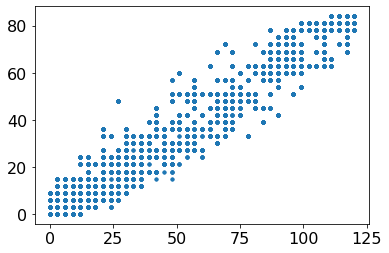

In [116]:
plt.figure();
plt.plot(c1_each_voxel, c2_each_voxel, '.')

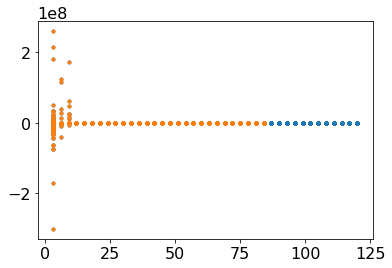

In [115]:

plt.figure();
plt.plot(c1_each_voxel,sem_discrim[0,dd,:],'.')
plt.plot(c2_each_voxel,sem_discrim[0,dd,:],'.')

In [127]:
np.mean(c1_each_voxel<10)

0.1279258283514034

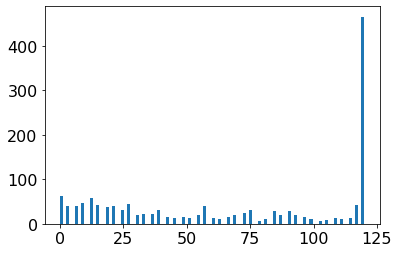

In [122]:
plt.figure();
plt.hist(c1,100);

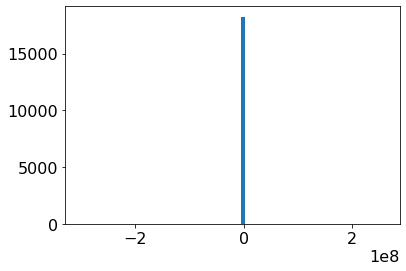

In [81]:
dd=15;
plt.figure();plt.hist(sem_discrim[0,dd,:],100);

In [84]:
np.sum(sem_discrim[0,dd,:]>10000)

32

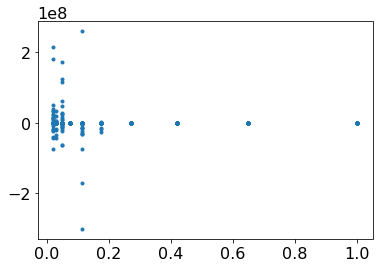

In [88]:
prf_inds = out['best_params'][5][:,0]
prf_sizes = out['best_params'][0][:,0,2]
plt.figure();
# plt.plot(prf_inds,sem_discrim[0,dd,:],'.')
plt.plot(prf_sizes,sem_discrim[0,dd,:],'.')

In [89]:
np.unique(prf_inds[np.abs(sem_discrim[0,dd,:])>10e6])

array([ 52,  82,  85,  94,  98, 217, 229, 348, 365, 385, 395, 645, 671,
       803])

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


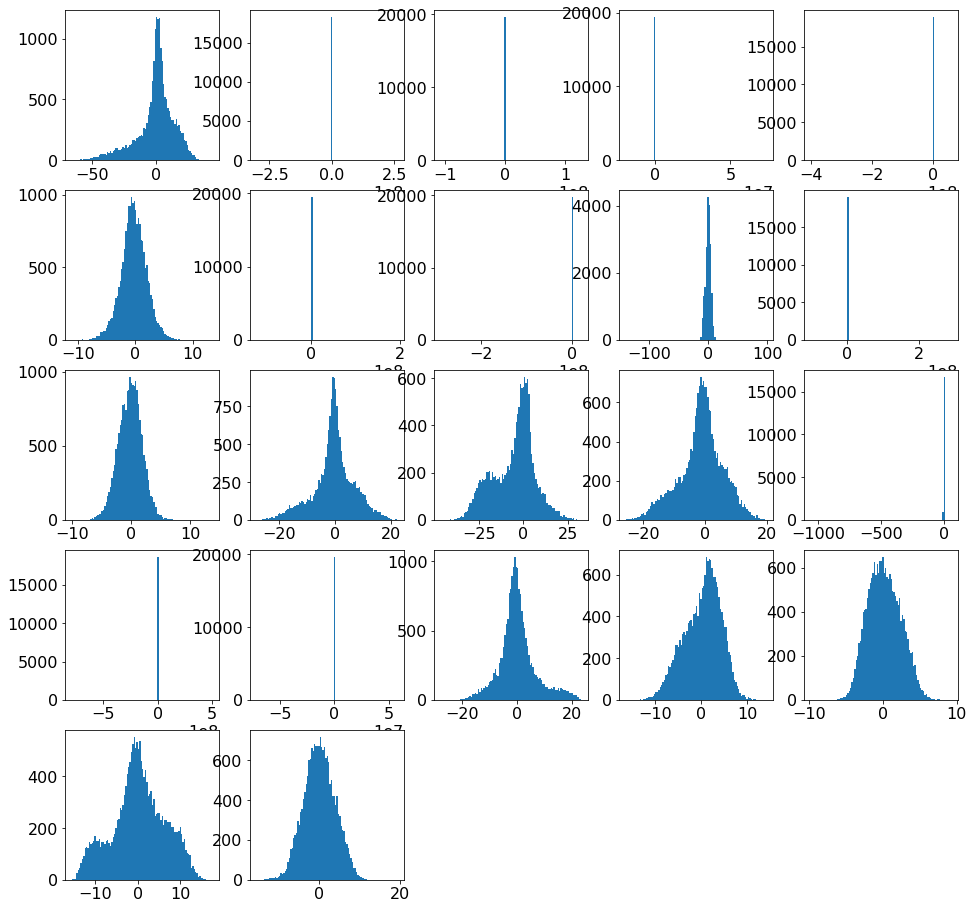

In [80]:
plt.figure(figsize=(16,16));
npx = np.ceil(np.sqrt(np.sum(has_missing)))
npy = np.ceil(np.sum(has_missing)/npx)
for di, dd in enumerate(np.where(has_missing)[0]):
    
    plt.subplot(npx, npy, di+1)
    plt.hist(sem_discrim[0,dd,:],100);

In [79]:
np.where(has_missing)[0]

array([13, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 27, 32, 41, 42, 43, 44,
       45, 49, 50, 51, 53])

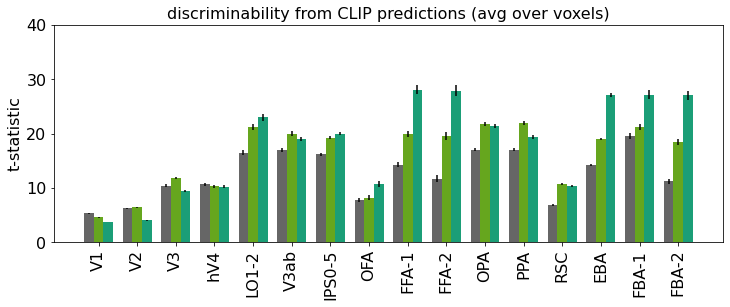

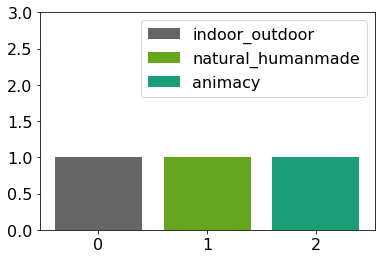

In [32]:
roi_names =roi_def.roi_names
skip_inds = [4,5,7,10,11,15,16,23]
areas2plot = np.arange(len(roi_names))
areas2plot = areas2plot[~np.isin(areas2plot, skip_inds)]
n_rois_plot = len(areas2plot)

dd2plot = [0,1,2]

discrim_type_colors = np.flipud(cm.Dark2(np.linspace(0,1,len(dd2plot))))
bar_jitters = np.linspace(-0.25, 0.25,len(dd2plot))
bar_width = np.diff(bar_jitters[0:2])[0]
    
vox2use = clip_r2>0.01

plt.figure(figsize=(12,4));
    
mean_val_each_roi = np.zeros((len(dd2plot), len(areas2plot)))
std_val_each_roi = np.zeros((len(dd2plot), len(areas2plot)))
n_each_roi = np.zeros((len(areas2plot),))

for di, dd in enumerate(dd2plot):
  
    discrim_type = discrim_type_list[dd]

    for ri, rr in enumerate(areas2plot):
        
        inds_this_roi = roi_def.get_indices(rr)

        inds_this_roi = inds_this_roi & vox2use

        vals = np.abs(sem_discrim[fi,dd,inds_this_roi])

        if len(vals)==0:
            print('no voxels in %s'%roi_names[rr])
            continue

        n_each_roi[ri] = len(vals)
        mean_val_each_roi[di,ri] = np.mean(vals)
        std_val_each_roi[di,ri] = np.std(vals)
    
    plt.bar(np.arange(n_rois_plot)+bar_jitters[di],mean_val_each_roi[di,:],\
            width=bar_width, color=discrim_type_colors[di,:])
    plt.errorbar(np.arange(n_rois_plot)+bar_jitters[di],mean_val_each_roi[di,:],\
                 std_val_each_roi[di,:]/np.sqrt(n_each_roi), ecolor='k', \
                ls='none',zorder=10)

plt.xticks(np.arange(n_rois_plot), labels=np.array(roi_names)[areas2plot], rotation=90);
plt.ylabel('t-statistic')
plt.title('discriminability from CLIP predictions (avg over voxels)')
plt.ylim([0,40])

plt.figure();
for di in range(len(dd2plot)):
    plt.bar([di],[1],color=discrim_type_colors[di,:])
plt.ylim([0,3])
plt.legend([discrim_type_list[dd] for dd in dd2plot])

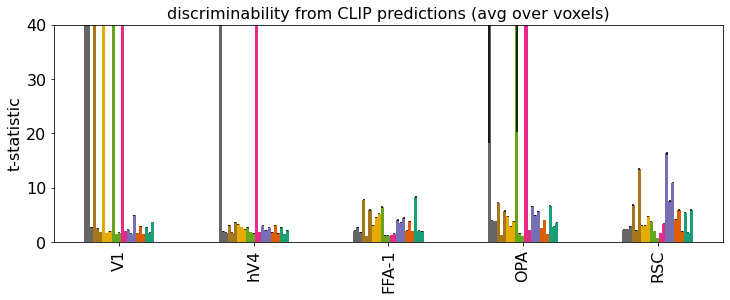

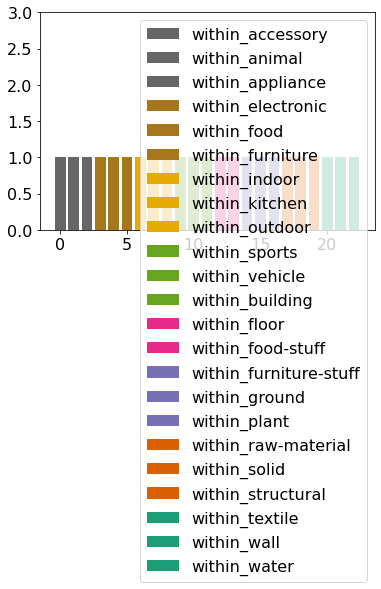

In [53]:
roi_names =roi_def.roi_names
areas2plot = [0,3,13,17,19]
n_rois_plot = len(areas2plot)

dd2plot = np.where(np.array(['within_' in name for name in discrim_type_list]))[0]
# dd2plot = np.where(~has_missing & np.array(['within_' in name for name in discrim_type_list]))[0]

discrim_type_colors = np.flipud(cm.Dark2(np.linspace(0,1,len(dd2plot))))
bar_jitters = np.linspace(-0.25, 0.25,len(dd2plot))
bar_width = np.diff(bar_jitters[0:2])[0]
    
vox2use = clip_r2>0.01

plt.figure(figsize=(12,4));
    
mean_val_each_roi = np.zeros((len(dd2plot), len(areas2plot)))
std_val_each_roi = np.zeros((len(dd2plot), len(areas2plot)))
n_each_roi = np.zeros((len(areas2plot),))

for di, dd in enumerate(dd2plot):
  
    discrim_type = discrim_type_list[dd]

    for ri, rr in enumerate(areas2plot):
        
        inds_this_roi = roi_def.get_indices(rr)

        inds_this_roi = inds_this_roi & vox2use

        vals = np.abs(sem_discrim[fi,dd,inds_this_roi])

        if len(vals)==0:
            print('no voxels in %s'%roi_names[rr])
            continue

        n_each_roi[ri] = len(vals)
        mean_val_each_roi[di,ri] = np.nanmean(vals)
        std_val_each_roi[di,ri] = np.nanstd(vals)
    
    plt.bar(np.arange(n_rois_plot)+bar_jitters[di],mean_val_each_roi[di,:],\
            width=bar_width, color=discrim_type_colors[di,:])
    plt.errorbar(np.arange(n_rois_plot)+bar_jitters[di],mean_val_each_roi[di,:],\
                 std_val_each_roi[di,:]/np.sqrt(n_each_roi), ecolor='k', \
                ls='none',zorder=10)

plt.xticks(np.arange(n_rois_plot), labels=np.array(roi_names)[areas2plot], rotation=90);
plt.ylabel('t-statistic')
plt.title('discriminability from CLIP predictions (avg over voxels)')
plt.ylim([0,40])

plt.figure();
for di in range(len(dd2plot)):
    plt.bar([di],[1],color=discrim_type_colors[di,:])
plt.ylim([0,3])
plt.legend([discrim_type_list[dd] for dd in dd2plot])

In [69]:
from utils import coco_utils
cat_objects, cat_names, cat_ids, supcat_names, ids_each_supcat = \
            coco_utils.get_coco_cat_info(coco_utils.coco_val)

stuff_cat_objects, stuff_cat_names, stuff_cat_ids, stuff_supcat_names, stuff_ids_each_supcat = \
        coco_utils.get_coco_cat_info(coco_utils.coco_stuff_val)


Initializing coco api...
loading annotations into memory...
Done (t=0.59s)
creating index...
index created!
loading annotations into memory...
Done (t=16.72s)
creating index...
index created!
Initializing coco api...
loading annotations into memory...
Done (t=0.49s)
creating index...
index created!
loading annotations into memory...
Done (t=15.40s)
creating index...
index created!


In [94]:

kk = 
for ki, kk in enumerate(supcat_names):
    print(kk)
    subcat_names = top_two['things_top_two'][kk]
    print(subcat_names)
    ii1 = np.where([name==subcat_names[0] for name in cat_names])[0][0]
    ii2 = np.where([name==subcat_names[1] for name in cat_names])[0][0]
    c1 = counts['things_cat_counts_valtrials'][:,:,ii1]
    c2 = counts['things_cat_counts_valtrials'][:,:,ii1]
    print(np.min(c1), np.min(c2))
   

accessory
['handbag', 'backpack']
0.0 0.0
animal
['cat', 'dog']
0.0 0.0
appliance
['sink', 'oven']
0.0 0.0
electronic
['tv', 'cell phone']
0.0 0.0
food
['pizza', 'cake']
0.0 0.0
furniture
['dining table', 'chair']
29.0 29.0
indoor
['clock', 'book']
0.0 0.0
kitchen
['cup', 'bowl']
2.0 2.0
outdoor
['bench', 'traffic light']
3.0 3.0
person
[]


IndexError: list index out of range

In [65]:
max_each_dim = np.nanmax(np.nanmax(sem_discrim, axis=2), axis=0)
for ii in np.arange(0,60,5):
    print(max_each_dim[ii:ii+5].round(2))

[53.88 62.14 65.07 17.27 36.97]
[24.5  19.57 38.76 28.62 22.99]
[26.17 14.14 44.71 43.98 26.2 ]
[2.59453928e+08 1.26426653e+08 7.36755882e+07 5.73568987e+07
 1.33800000e+01]
[1.95800000e+01 1.92037644e+08 2.10968757e+07 9.77000000e+01
 2.88343958e+08]
[13.64 26.86 22.13 27.95 23.95]
[36.59 31.49 32.69 30.86 19.88]
[34.4  16.2  18.93 22.36 29.15]
[2.35000000e+01 1.97100000e+01 5.25300000e+01 4.96946590e+08
 5.70220299e+07]
[23.49 12.59 14.83  9.48 14.03]
[ 9.21 17.41  9.94 19.08]
[]


In [67]:
np.array(discrim_type_list)[max_each_dim>100]

array(['within_accessory', 'within_animal', 'within_appliance',
       'within_electronic', 'within_indoor', 'within_kitchen',
       'within_sports', 'within_floor', 'within_food-stuff'], dtype='<U22')

In [67]:
np.whe(discrim_type_list)[max_each_dim>100]

array(['within_accessory', 'within_animal', 'within_appliance',
       'within_electronic', 'within_indoor', 'within_kitchen',
       'within_sports', 'within_floor', 'within_food-stuff'], dtype='<U22')

In [55]:
np.max(mean_val_each_roi)

1047124.8922729373

In [42]:
np.array(roi_names)

array(['V1', 'V2', 'V3', 'hV4', 'VO1-2', 'PHC1-2', 'LO1-2', 'TO1-2',
       'V3ab', 'IPS0-5', 'SPL1', 'FEF', 'OFA', 'FFA-1', 'FFA-2',
       'mTL-faces', 'aTL-faces', 'OPA', 'PPA', 'RSC', 'EBA', 'FBA-1',
       'FBA-2', 'mTL-bodies'], dtype='<U10')

In [43]:
areas2plot = [0,3,13,17,19]

In [46]:
np.array(roi_names)[areas2plot]

array(['V1', 'hV4', 'FFA-1', 'OPA', 'RSC'], dtype='<U10')